# Timeseries et machine learning

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Les séries temporelles diffèrent des problèmes de machine learning classique car les observations ne sont pas indépendantes. Ce notebook présente quelques traitements classiques et une façon assez simple d'appliquer un traitement de machine learning.

In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

Je ne vais pas refaire ici un cours sur les séries temporelles. Quelques références pour approfondir :
   
* [Différencier (indéfiniment) les séries temporelles ?](https://freakonometrics.hypotheses.org/1876)
* [Cours de Séries Temporelles - Arthur Charpentier](http://cours.mido.dauphine.fr/st/cours.html)
* [Modèles de prévision Séries temporelles](http://freakonometrics.free.fr/M1_TS_2015.pdf)
* [COURS DE SERIES TEMPORELLES THEORIE ET APPLICATIONS](https://perso.univ-rennes1.fr/arthur.charpentier/TS1.pdf)

## Données

Prenons comme exemple une série venant de [Google Trend](https://www.google.com/trends/), par exemple le terme [macron](https://www.google.com/trends/explore?geo=FR&q=macron) pris sur la France.

In [ ]:
from ensae_teaching_cs.data import google_trends
t = google_trends("macron") # export CSV, donc pas à jour
import pandas
df = pandas.read_csv(t, sep=",")
df.tail()

,Week,macron
256,2016-08-21,9
257,2016-08-28,98
258,2016-09-04,34
259,2016-09-11,17
260,2016-09-18,13


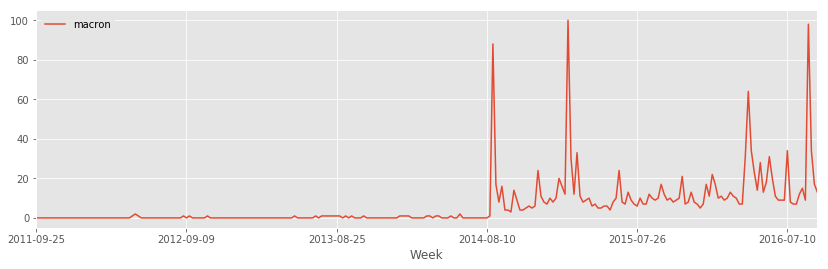

In [ ]:
df.plot(x="Week", y="macron", figsize=(14,4))

## Période, tendance

On enlève tout ce qui précède 08/2014 car la série se comporte de façon différente. Monsieur Macron n'était probablement pas ministre à avant cette date.

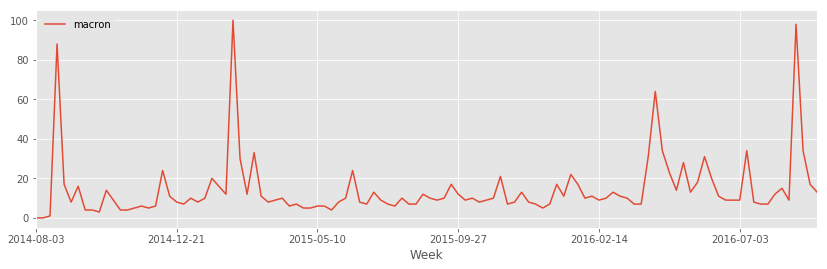

In [ ]:
df[df.Week >= "2014-08"].plot(x="Week", y="macron", figsize=(14,4))

On peut étudier les corrélations entre les différentes dates. Le module le plus approprié est [statsmodels](http://statsmodels.sourceforge.net/devel/index.html).

In [ ]:
data = df[df.Week >= "2014-08"].copy()

La série ne montre pas de période évidente. Regardons la tendance.

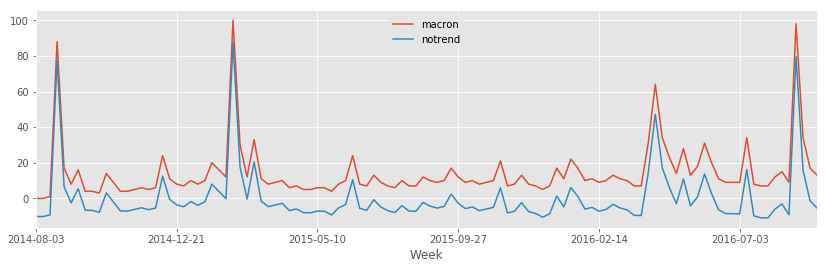

In [ ]:
from statsmodels.tsa.tsatools import detrend
notrend = detrend(data.macron)
data["notrend"] = notrend
data.plot(x="Week", y=["macron", "notrend"], figsize=(14,4))

On vérifie pour la période.

In [ ]:
from statsmodels.tsa.stattools import acf
cor = acf(data.notrend)
cor

array([  1.00000000e+00,   1.81478584e-01,   7.71694317e-03,
         6.10314527e-02,  -3.12083821e-02,  -5.82876827e-02,
        -3.76040376e-02,   7.26138869e-02,  -4.37474938e-02,
        -8.95598327e-02,  -6.59322125e-02,  -7.63327292e-02,
        -3.54159381e-02,   3.38419910e-02,  -2.35595163e-02,
        -4.74118451e-02,  -3.53898523e-02,  -1.37790825e-02,
        -1.21436276e-02,   9.54084115e-03,   1.10601624e-01,
         4.84432935e-02,   8.45674666e-03,  -5.47832160e-02,
        -1.72073748e-02,   2.16452288e-01,   1.08989553e-03,
        -3.85780099e-02,   2.84947228e-04,  -1.77271624e-02,
        -2.46716340e-02,   1.34294810e-02,   2.34894397e-02,
        -2.82512712e-02,  -1.76425935e-02,  -3.77660611e-02,
        -6.79376963e-02,  -5.36774061e-02,  -2.86750133e-02,
        -4.95528192e-02,  -4.18258630e-02])

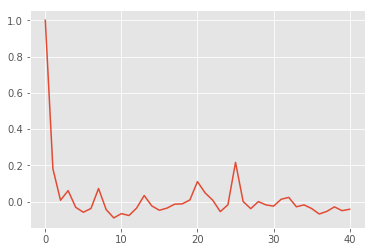

In [ ]:
plt.plot(cor)

## Auto-corrélation

On recommence sur la série [chocolat](https://www.google.com/trends/explore?geo=FR&q=chocolat).

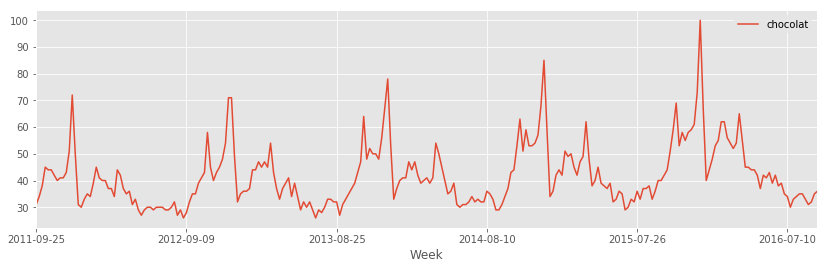

In [ ]:
choco = pandas.read_csv(google_trends("chocolat"), sep=",")
choco.plot(x="Week", y="chocolat", figsize=(14,4))

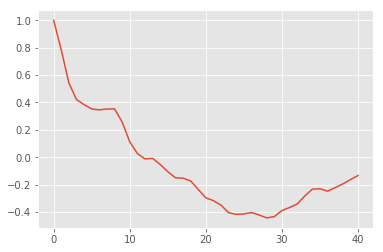

In [ ]:
choco["notrend"] = detrend(choco.chocolat)
cor = acf(choco.notrend)
plt.plot(cor)

On regarde plus souvent les [auto-corrélations partielles](https://en.wikipedia.org/wiki/Partial_autocorrelation_function).

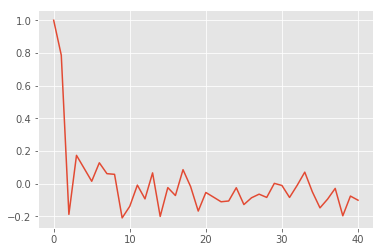

In [ ]:
from statsmodels.tsa.stattools import pacf
pcor = pacf(choco.notrend)
plt.plot(pcor)

## Tendance

[detrend](http://statsmodels.sourceforge.net/stable/generated/statsmodels.tsa.tsatools.detrend.html#statsmodels.tsa.tsatools.detrend) ne semble pas retourner la tendance. Il faut utiliser la régression pour cela.

In [ ]:
from statsmodels.api import OLS
import numpy
y = data.macron
X = numpy.ones((len(y), 2))
X[:,1] = numpy.arange(0,len(y))
reg = OLS(y,X)
results = reg.fit()
results.params

const    10.137010
x1        0.075234
dtype: float64

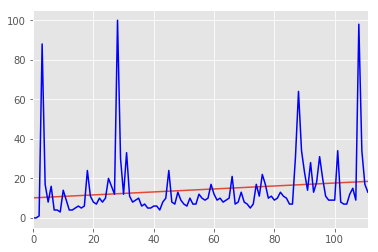

In [ ]:
from statsmodels.graphics.regressionplots import abline_plot
fig = abline_plot(model_results=results)
ax = fig.axes[0]
ax.plot(X[:,1], y, 'b')
ax.margins(.1)

## Prédictions linéaires

On sort ici du cadre linéaire pour utiliser le machine learning non linéaire pour faire de la prédiction. Pour éviter les trop gros problèmes de tendance, on travaillera sur la série différenciée. En théorie, il faudrait différencier jusqu'à ce qu'on enlève la tendance (voir [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)).

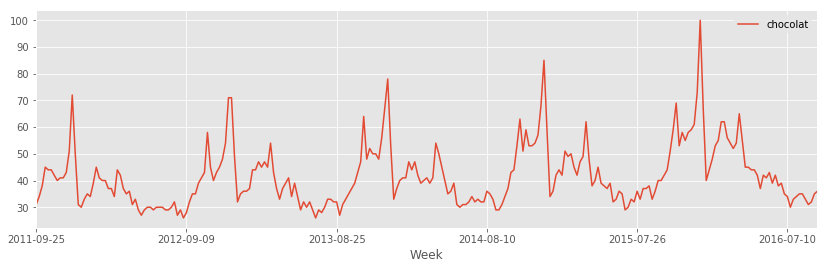

In [ ]:
from ensae_teaching_cs.data import google_trends
df = pandas.read_csv(google_trends("chocolat"), sep=",")
df.plot(x="Week", y="chocolat", figsize=(14,4))

On calcule la série différenciée. Quelques astuces. [pandas](http://pandas.pydata.org/) utilise les indices par défaut pour faire des opérations sur les colonnes. C'est pourquoi il faut convertir les tableaux extraits du dataframe en [numpy array](http://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html). **N'oubliez pas ce détail. C'est très agaçant**. On peut aussi utiliser la fonction [diff](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.diff.html).

In [ ]:
df["diff"] = numpy.nan
df.ix[1:, "diff"] = (df.iloc[1:, 1].as_matrix() - df.iloc[:len(df)-1, 1].as_matrix())
pandas.concat([df.head(n=3), df.tail(n=3)])

,Week,chocolat,diff
0,2011-09-25,31,NaN
1,2011-10-02,34,3.0
2,2011-10-09,38,4.0
258,2016-09-04,32,1.0
259,2016-09-11,35,3.0
260,2016-09-18,36,1.0


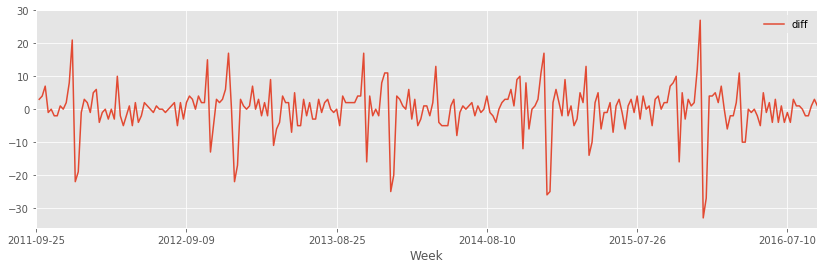

In [ ]:
df.plot(x="Week", y="diff", figsize=(14,4))

Sans information, la meilleure prédiction est la valeur de la veille (où celle dans le passé à l'horizon de prédiction considéré). Dans notre cas, c'est simplement la variance de la série différenciée :

In [ ]:
(df["diff"].apply(lambda x:x**2).sum()/len(df))**0.5

7.1682035240673869

In [ ]:
from statsmodels.tsa.arima_model import ARMA
arma_mod = ARMA(df["diff"].dropna().as_matrix(), order=(8, 1))
res = arma_mod.fit()
res.params

array([-0.00318712,  0.2332443 , -0.3239062 , -0.13429128, -0.05203156,
       -0.13237594,  0.00292422, -0.06093002,  0.18300775, -0.25978782])

**à finir** train/test / prédiciton

## Machine learning

On souhaite utiliser une random forest pour faire de la prédiction. On créé la matrice avec les séries décalées.

In [ ]:
from statsmodels.tsa.tsatools import lagmat
lag = 8
X = lagmat(df["diff"], lag)
lagged = df.copy()
for c in range(1,lag+1):
    lagged["lag%d" % c] = X[:, c-1]
pandas.concat([lagged.head(), lagged.tail()])

,Week,chocolat,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
0,2011-09-25,31,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-10-02,34,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-10-09,38,4.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-10-16,45,7.0,4.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0
4,2011-10-23,44,-1.0,7.0,4.0,3.0,NaN,0.0,0.0,0.0,0.0
256,2016-08-21,33,-2.0,0.0,1.0,1.0,3.0,-4.0,-1.0,-4.0,1.0
257,2016-08-28,31,-2.0,-2.0,0.0,1.0,1.0,3.0,-4.0,-1.0,-4.0
258,2016-09-04,32,1.0,-2.0,-2.0,0.0,1.0,1.0,3.0,-4.0,-1.0
259,2016-09-11,35,3.0,1.0,-2.0,-2.0,0.0,1.0,1.0,3.0,-4.0
260,2016-09-18,36,1.0,3.0,1.0,-2.0,-2.0,0.0,1.0,1.0,3.0


On découpe en train/test de façon non aléatoire car c'est une série temporelle.

In [ ]:
xc = ["lag%d" % i for i in range(1,lag+1)]
split = 0.66
isplit = int(len(lagged) * split)
xt = lagged[10:][xc]
yt = lagged[10:]["diff"]
X_train, y_train, X_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]

On peut maintenant faire du machine learning sur la série décalé.

In [ ]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test.as_matrix(), clr.predict(X_test))
r2

0.19464363031161369

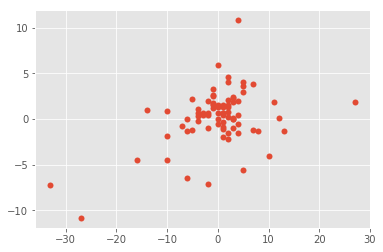

In [ ]:
plt.scatter(y_test.as_matrix(), clr.predict(X_test))

Non linéaire

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clrf = RandomForestRegressor()
clrf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test.as_matrix(), clrf.predict(X_test))
r2

0.36452852422907478

C'est mieux.

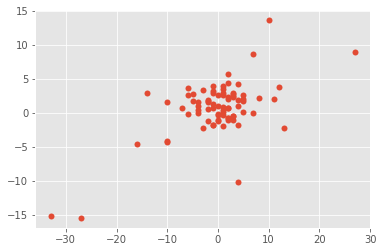

In [ ]:
plt.scatter(y_test.as_matrix(), clrf.predict(X_test))

Le modèle prédit bien les extrêmes, il faudrait sans doute les enlever ou utiliser une échelle logarithmique pour réduire leur importance.